# Klasifikacija teksta

U ovoj svesci proći ćemo ponovo kroz primer koji smo uveli u priči o konvolutivnim neuronskim mrežama. Bavićemo se klasifikacijom IMDB filmskih pregleda na pozitivne i negativne, ali ovoga puta uz korišćenje rekurentnih neuronskih mreža. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU, Flatten, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam

Ovaj paket ćemo iskoristiti za praćenje vremena traniranja.

In [4]:
from time import perf_counter

## Priprema skupa podataka

Podsetimo se da prilikom učitavanja skupova za učenje i testiranje treba naglasiti sa kojom veličinom vokabulara želimo da radimo. Vokabular je uređen opadajuće po frekvenciji pojavljivanja reči, a navedeni broj predstavlja broj reči sa početka vokabulara. Ovde se zbog ograničenja zadržavamo na prvih 5000 reči. 

In [5]:
max_features = 5000

In [7]:
(X_train, y_train), (X_test, y_test)= imdb.load_data(num_words=max_features)

In [8]:
print('Skup za treniranje: ', X_train.shape)
print('Skup za testriranje: ', X_test.shape)

Skup za treniranje:  (25000,)
Skup za testriranje:  (25000,)


Podsetimo se i da je jedan ovako učitani pregled niz indeksa reči vokabulara. Nulama su predstavljene reči koje nisu pokrivene vokabularom.

In [9]:
print(X_train[3])

[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153, 103, 4, 1494, 13, 70, 131, 67, 11, 61, 2, 744, 35, 3715, 761, 61, 2, 452, 2, 4, 985, 7, 2, 59, 166, 4, 105, 216, 1239, 41, 1797, 9, 15, 7, 35, 744, 2413, 31, 8, 4, 687, 23, 4, 2, 2, 6, 3693, 42, 38, 39, 121, 59, 456, 10, 10, 7, 265, 12, 575, 111, 153, 159, 59, 16, 1447, 21, 25, 586, 482, 39, 4, 96, 59, 716, 12, 4, 172, 65, 9, 579, 11, 2, 4, 1615, 5, 2, 7, 2, 17, 13, 2, 12, 19, 6, 464, 31, 314, 11, 2, 6, 719, 605, 11, 8, 202, 27, 310, 4, 3772, 3501, 8, 2722, 58, 10, 10, 537, 2116, 180, 40, 14, 413, 173, 7, 263, 112, 37, 152, 377, 4, 537, 263, 846, 579, 178, 54, 75, 71, 476, 36, 413, 263, 2504, 182, 5, 17, 75, 2306, 922, 36, 279, 131, 2895, 17, 2867, 42, 17, 35, 921, 2, 192, 5, 1219, 3890, 19, 2, 217, 4122, 1710, 537, 2, 1236, 5, 736, 10, 10, 61, 403, 9, 2, 40, 61, 4494, 5, 27, 4494, 159, 90, 263, 2311, 4319, 309, 8, 178, 5, 82, 4319, 4, 65, 15, 2, 145, 143, 2, 12, 2, 537, 746, 537, 537, 15, 2, 4, 2, 594, 7, 2, 94, 2, 3987, 2, 11, 2, 4, 538,

In [10]:
len(X_train[0])

218

Očekuje se i da pre obrade sve preglede svedemo na iste dužine. Mi ćemo se opredeliti za dužinu od 500 reči. Pregledi koji sadrže manje reći biće dopunjeni nulama, a pregledi koji sadrže više reči biće skraćeni.

In [11]:
maxlen = 500

In [12]:
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [13]:
print(X_train.shape)

(25000, 500)


In [14]:
print(X_test.shape)

(25000, 500)


Za dalje predstavljanje reči iskoristićemo ugnježdavanja u semantički prostor dimenzije `embedding_dimensionality` pomoću sloja `Embedding`.

Ciljna promenljiva sadrži samo vrednosti 0 i 1 koje redom opisuju negativne i pozitivne preglede. Broj pozitivnih i broj negativnih pregleda je isti.

In [15]:
np.unique(y_train)

array([0, 1])

In [16]:
negative_review = np.sum(y_train == 0)
positive_review = np.sum(y_train == 1)

In [17]:
print('Broj pozitivnih pregleda: ', positive_review)
print('Broj negitivnih pregleda: ', negative_review)

Broj pozitivnih pregleda:  12500
Broj negitivnih pregleda:  12500


Ovu funkciju ćemo iskoristiti za iscrtavanje grafika tačnosti i funkcije gubitka nakon treniranja.

In [18]:
def plot_graphs(history, epoches):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Accuracy')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(range(0, epoches), accuracy, color='red', label='training')
    plt.plot(range(0, epoches), val_accuracy, color='orange', label='validation')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title('Loss')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(0, epoches), loss, color='red', label='training')
    plt.plot(range(0, epoches), val_loss, color='orange', label='validation')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    
    plt.show()

Nadalje ćemo eksperimentisati sa različitim rekurentnim arhitekturama. Mreže koje ćemo konstruisati će biti plitke i trenirane u malom broju epoha tako da se za vežbu predlaže istraživanje ponašanja mreže sa većim brojem epoha, dodatnim regularizacijama i manjim koracima učenja. Takođe, mogu se varirati veličina ugnježđene reprezentacije i velilčina izlaza.

## Jednostavna rekurentne neuronska mreža

In [44]:
embedding_dimensionality = 32
output_size = 128

In [45]:
model_simple = Sequential([
    Embedding(max_features, embedding_dimensionality, input_length=maxlen),
    SimpleRNN(units=output_size),
    Dropout(rate=0.2),
    Dense(1, activation='sigmoid')
])

In [46]:
model_simple.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               20608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 180,737
Trainable params: 180,737
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_simple.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
epoches = 5
batch_size = 128

In [49]:
# treniranje mreze traje nesto duze
start_training_simple = perf_counter()
history_simple = model_simple.fit(X_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
end_training_simple = perf_counter()

Epoch 1/5
157/157 [==============================] - 69s 439ms/step - loss: 0.6970 - accuracy: 0.5005 - val_loss: 0.6945 - val_accuracy: 0.5068
Epoch 2/5
157/157 [==============================] - 67s 425ms/step - loss: 0.6943 - accuracy: 0.5120 - val_loss: 0.6936 - val_accuracy: 0.5122
Epoch 3/5
157/157 [==============================] - 74s 473ms/step - loss: 0.6925 - accuracy: 0.5185 - val_loss: 0.6902 - val_accuracy: 0.5402
Epoch 4/5
157/157 [==============================] - 65s 413ms/step - loss: 0.6885 - accuracy: 0.5400 - val_loss: 0.6885 - val_accuracy: 0.5398
Epoch 5/5
157/157 [==============================] - 74s 473ms/step - loss: 0.6863 - accuracy: 0.5521 - val_loss: 0.6857 - val_accuracy: 0.5550


In [50]:
print('Duzina trajanja treniranja (u sekundama): ', end_training_simple-start_training_simple)

Duzina trajanja treniranja (u sekundama):  352.062345616


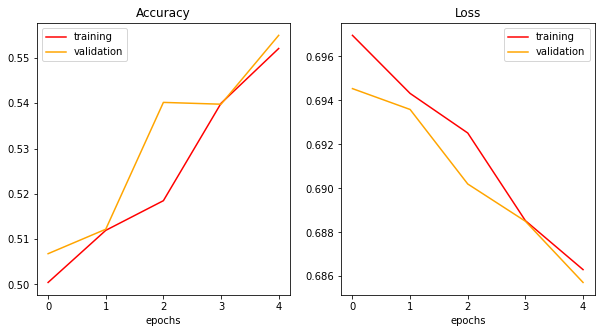

In [51]:
plot_graphs(history_simple, epoches)

In [52]:
loss_simple, accuracy_simple = model_simple.evaluate(X_test, y_test)

782/782 [==============================] - 41s 53ms/step - loss: 0.6875 - accuracy: 0.5463


In [53]:
print('Loss: ', loss_simple)

Loss:  0.6875303387641907


In [54]:
print('Accuracy: ', accuracy_simple)

Accuracy:  0.5463200211524963


Podsetimo se, za čuvanje modela može da se iskoristi funkcija `save`.

In [64]:
# model_simple.save('models/simpleRNN.h5')

### LSTM rekurentna neuronska mreža 

In [65]:
embedding_dimensionality = 32
units = 128

In [66]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embedding_dimensionality, input_length=maxlen))
model_lstm.add(LSTM(units))
model_lstm.add(Dropout(rate=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

In [67]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_lstm.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
epoches = 3
batch_size = 128

In [70]:
# treniranje mreze traje nesto duze 
start_training_lstm = perf_counter()
history_lstm = model_lstm.fit(X_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
end_training_lstm = perf_counter()

Epoch 1/3
157/157 [==============================] - 273s 2s/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6930 - val_accuracy: 0.5236
Epoch 2/3
157/157 [==============================] - 238s 2s/step - loss: 0.6930 - accuracy: 0.5246 - val_loss: 0.6929 - val_accuracy: 0.5436
Epoch 3/3
157/157 [==============================] - 231s 1s/step - loss: 0.6928 - accuracy: 0.5459 - val_loss: 0.6927 - val_accuracy: 0.5600


In [71]:
print('Duzina trajanja treniranja (u sekundama): ', end_training_lstm-start_training_lstm)

Duzina trajanja treniranja (u sekundama):  749.4394786689991


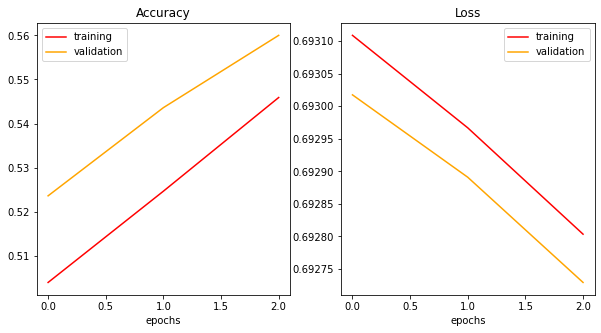

In [72]:
plot_graphs(history_lstm, epoches)

In [73]:
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)

782/782 [==============================] - 147s 187ms/step - loss: 0.6927 - accuracy: 0.5624


In [74]:
print('Loss: ', loss_lstm)

Loss:  0.6927489638328552


In [75]:
print('Accuracy: ', accuracy_lstm)

Accuracy:  0.5624399781227112


In [76]:
# model_lstm.save('models/LSTM.h5')

### Stekovana LSTM mreže

In [81]:
embedding_dimensionality = 32
units = 128

In [82]:
model_stacked_lstm = Sequential([
    Embedding(max_features, embedding_dimensionality, input_length=maxlen),
    LSTM(units, return_sequences=True),
    LSTM(units), 
    Dropout(rate=0.2),
    Dense(1, activation='sigmoid')
])

In [83]:
model_stacked_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 128)          82432     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 374,145
Trainable params: 374,145
Non-trainable params: 0
_________________________________________________________________


In [84]:
model_stacked_lstm.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
epoches = 5
batch_size = 128

In [86]:
start_training_stacked_lstm = perf_counter()
history_stacked_lstm = model_stacked_lstm.fit(X_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
end_training_stacked_lstm = perf_counter()

Epoch 1/5
157/157 [==============================] - 521s 3s/step - loss: 0.6931 - accuracy: 0.5110 - val_loss: 0.6930 - val_accuracy: 0.5380
Epoch 2/5
157/157 [==============================] - 520s 3s/step - loss: 0.6928 - accuracy: 0.5551 - val_loss: 0.6927 - val_accuracy: 0.5616
Epoch 3/5
157/157 [==============================] - 525s 3s/step - loss: 0.6923 - accuracy: 0.5670 - val_loss: 0.6919 - val_accuracy: 0.5768
Epoch 4/5
157/157 [==============================] - 488s 3s/step - loss: 0.6876 - accuracy: 0.6121 - val_loss: 0.6612 - val_accuracy: 0.6550
Epoch 5/5
157/157 [==============================] - 410s 3s/step - loss: 0.5924 - accuracy: 0.6943 - val_loss: 0.5536 - val_accuracy: 0.7298


In [87]:
print('Duzina trajanja treniranja (u sekundama): ', end_training_stacked_lstm-start_training_stacked_lstm)

Duzina trajanja treniranja (u sekundama):  2490.838220345


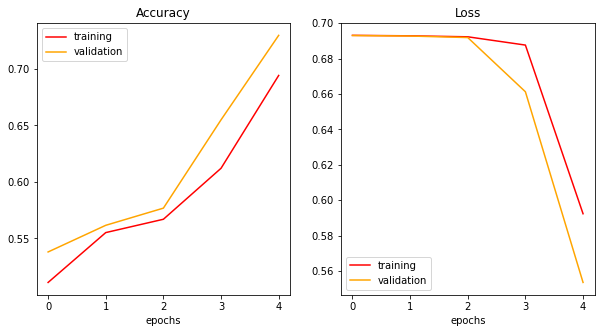

In [88]:
plot_graphs(history_stacked_lstm, epoches)

In [89]:
model_stacked_lstm.save('models/LSTM_stacked.h5')

### GRU rekurentna neuronska mreža 

In [90]:
embedding_dimensionality = 32
units = 128

In [91]:
model_gru = Sequential()
model_gru.add(Embedding(max_features, embedding_dimensionality, input_length=maxlen))
model_gru.add(GRU(units))
model_gru.add(Dropout(rate=0.2))
model_gru.add(Dense(1, activation='sigmoid'))

In [92]:
model_gru.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
gru (GRU)                    (None, 128)               62208     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 222,337
Trainable params: 222,337
Non-trainable params: 0
_________________________________________________________________


In [93]:
model_gru.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
epoches = 5
batch_size = 128

In [95]:
# treniranje mreze traje nesto duze - istrenirani model je dostupan u models direktorijumu
start_training_gru = perf_counter()
history_gru = model_gru.fit(X_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
end_training_gru = perf_counter()

Epoch 1/5
157/157 [==============================] - 157s 1000ms/step - loss: 0.6917 - accuracy: 0.5469 - val_loss: 0.6886 - val_accuracy: 0.6038
Epoch 2/5
157/157 [==============================] - 172s 1s/step - loss: 0.5861 - accuracy: 0.7067 - val_loss: 0.4040 - val_accuracy: 0.8288
Epoch 3/5
157/157 [==============================] - 150s 955ms/step - loss: 0.3593 - accuracy: 0.8523 - val_loss: 0.3273 - val_accuracy: 0.8616
Epoch 4/5
157/157 [==============================] - 247s 2s/step - loss: 0.2905 - accuracy: 0.8852 - val_loss: 0.3029 - val_accuracy: 0.8766
Epoch 5/5
157/157 [==============================] - 182s 1s/step - loss: 0.2559 - accuracy: 0.9005 - val_loss: 0.3043 - val_accuracy: 0.8742


In [96]:
print('Duzina trajanja treniranja: ', end_training_gru-start_training_gru)

Duzina trajanja treniranja:  837.5226644699978


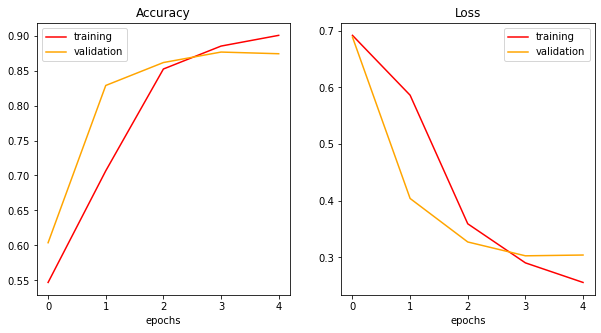

In [97]:
plot_graphs(history_gru, epoches)

In [98]:
loss_gru, accuracy_gru = model_gru.evaluate(X_test, y_test)

782/782 [==============================] - 74s 95ms/step - loss: 0.3096 - accuracy: 0.8709


In [99]:
print('Loss: ', loss_gru)

Loss:  0.309600293636322


In [100]:
print('Accuracy: ', accuracy_gru)

Accuracy:  0.8709200024604797


In [101]:
model_gru.save('models/GRU.h5')

### Neuronska mreža sa pritreniranim ugnježđavanjima

Isprobaćemo i varijantu mreže koja će koristiti pritrenirane ugnježđene reprezentacije. Ovakve reprezentacije se obično uče nad većim skupom podataka i mogu biti korisne za mnoge zadatke u kojima je raspoloživi skup mnogo manjeg obima. O načinima njihovog učenja biće više reči u sekciji o nenadgledanom mašinskom učenju, a ove ćemo iskoristiti `GloVe` reprezentacije. Ceo paket sa reprezentacijama reči različitih dužina (50, 100, 200 i 300) ukupne veličine 822MB se može preuzeti sa [zvanične adrese](https://nlp.stanford.edu/projects/glove/) Stanford grupe. Mi ćemo u radu koristiti reprezentacije dužine 100 koje se nalaze u datoteci `glove.6B.100d.txt` (347.1MB) koja se može preuzeti pojedinačno npr. sa [ove](https://www.kaggle.com/terenceliu4444/glove6b100dtxt) adrese. 

Prvo ćemo pročitati iz preuzete datoteke sve podržane reči i njihove vektorske reprezentacije. U pojedinačnim redovima datoteke se prvo nalazi reči, a potom 100 realnih vrednosti koje predstavljaju njenu vektorsku reprezentaciju.

In [102]:
word_embeddings = {}
with open('data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

In [103]:
len(word_embeddings)

400000

Na primer, vektorska reprezentacija reči `movie` se može dobiti sa:

In [104]:
word_embeddings['movie']

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

Prilikom učenja ovakvih reprezentacija obično se ne vrši priprema teksta na način koji smo opisivali u generisanju `Tf-Idf` reprezentacija (normalizacija, stemiranje, lematizacija) kako bi mreža mogla da nauči različite aspekte pojedinačnih reči. Tako za imenicu movie postoji i reprezentacija reči movies, a za glagol play i reprezentacije za plays, playing i played.

Da bismo mogli da mapiramo filmske izveštaje u reči, a potom i reči u vektorske reprezentacije, sa forme pregleda koji sadrži indekse reči trebamo preći na formu koja sadrži konkretne reči. 

Ovde ćemo simulirati ceo proces obrade teksta korišćenjem Keras podrške obrađujući orginalne tekstualne sadržaje pregleda koji se mogu preuzeti sa [ove](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) adrese.

In [105]:
import pandas as pd
import re

In [106]:
reviews = pd.read_csv('data/IMDB.csv')

U pročitanom skupu se nalaze svi pregledi koje treba dalje razvrstati na skupove za treniranje, validaciju i testiranje.

In [107]:
reviews.shape

(50000, 2)

In [108]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Pozitivni sentiment ćemo mapirati u vrednost 1, a negativni u vrednost 0.

In [109]:
reviews['target'] = reviews['sentiment'].apply(lambda s: 1 if s=='positive' else 0)

In [110]:
reviews['target'].value_counts()

1    25000
0    25000
Name: target, dtype: int64

Zbog dalje obrade teksta, pročitaćemo i jedan originalni pregled.

In [111]:
demo_review = reviews['review'][0]

In [112]:
demo_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Iz ovako pročitanih dokumenata možemo izbrisati zaostale HTML etikete i zameniti višestruke beline jednostrukim. Takođe, možemo sve zapisati malim slovima.

In [113]:
def prepare_review(review):
    clean_review = re.sub('<.+?>', ' ', review)
    clean_review = re.sub('\s+', ' ', clean_review)
    return clean_review.lower()

In [114]:
prepare_review(demo_review)

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows

Ovako napisanu funkciju ćemo dalje primeniti nad svakim pregledom.

In [115]:
reviews['prepared_review'] = reviews['review'].apply(lambda r: prepare_review(r))

Dalje, da bismo izdvojili skup za treniranje, skup za validaciju i skup za testiranje, promešaćemo indekse skupova podataka - podrazumevano prvo imamo sve pozitivne preglede uzastopno, a zatim i sve negativne.

In [116]:
indices = np.arange(reviews.shape[0])
np.random.shuffle(indices)

Prateći brojke iz prethodnih primera, u test skup ćemo smestiti polovinu pregleda, a ostale ćemo podeliti na preglede za traniranje i validaciju.

In [117]:
number_of_reviews = reviews.shape[0]
test_reviews = reviews.iloc[indices[number_of_reviews//2:]]
validation_size = int(0.2*number_of_reviews)
train_reviews = reviews.iloc[indices[0:number_of_reviews//2-validation_size]]
validation_reviews = reviews.iloc[indices[number_of_reviews//2-validation_size:number_of_reviews//2]]

In [118]:
test_reviews.shape

(25000, 4)

In [119]:
train_reviews.shape

(15000, 4)

In [120]:
validation_reviews.shape

(10000, 4)

Obradu ćemo izvršiti korišćenjem Kerasovog `Tokenizer` tokenizatora. Njime se mogu izdvojiti pojedinačne reči tj. tokeni zadatog teksta i konstruisati vokabular željene dužine. Kao i u prethodnim primerima, iskoristićemo 5000 najfrekventnijih reči.

In [121]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [122]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_reviews['prepared_review'])

Vokabular koji je kreirao tokenizator se može dobiti pomoću `word_index` svojstva. On se sastoji od reči i indeksa njihovih pozicija.

In [123]:
word_index = tokenizer.word_index
print('Broj jedinstvenih reci (tokena): ', len(word_index))

Broj jedinstvenih reci (tokena):  71262


In [124]:
word_index['movie']

16

In [125]:
word_index['movies']

95

Na osnovu ovako dobijene mape i GloVe vrednosti kreiraćemo matricu ugnježđavanja nalik onoj koju je mreža učila do sada.

In [126]:
embedding_dimensionality = 100
number_of_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((number_of_words, embedding_dimensionality))

In [127]:
for word, i in word_index.items():
    if i >= max_features:
        break
    embedding_vector = word_embeddings.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
    # ukoliko rec teksta nema GloVe reprezentaciju, njoj ce odgovarati vektor nula

In [128]:
embedding_matrix.shape

(5000, 100)

Dalje ćemo korišćenjem tokenizatora transformisati tekst u niz indeksa reči. Za to ćemo koristiti njegovu metodu `text_to_sequence`. Potom ćemo dobijene sekvence svesti na istu dužinu korišćenjem funkcije `pad_sequence`.

In [129]:
train_sequences = tokenizer.texts_to_sequences(train_reviews['prepared_review'])
X_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
y_train = train_reviews['target']

In [130]:
test_sequences = tokenizer.texts_to_sequences(test_reviews['prepared_review'])
X_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)
y_test = test_reviews['target']

In [131]:
validation_sequences = tokenizer.texts_to_sequences(validation_reviews['prepared_review'])
X_validation = preprocessing.sequence.pad_sequences(validation_sequences, maxlen=maxlen)
y_validation = validation_reviews['target']

Ostalo je još da kreiramo i naučimo model koji koiristi matricu ugnježdavanja. Prilikom zadavanja Embedding sloja ovoga puta ćemo preko parametra `weights` naglasiti koje vrednosti treba koristiti, a kako njih ne treba menjati u toku učenja, postavićemo i `trainable` parametar na vrednost `False`.

In [155]:
model_with_glove = Sequential()
model_with_glove.add(Embedding(max_features, embedding_dimensionality, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_with_glove.add(Flatten())
model_with_glove.add(Dropout(rate=0.3))
model_with_glove.add(Dense(32, activation='relu'))
model_with_glove.add(Dropout(rate=0.3))
model_with_glove.add(Dense(1, activation='sigmoid'))
model_with_glove.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 100)          500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 50000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1600032   
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 2,100,065
Trainable params: 1,600,065
Non-trainable params: 500,000
_____________________________________

In [156]:
model_with_glove.compile(optimizer=Adam(0.000001), loss='binary_crossentropy', metrics=['accuracy'])

In [157]:
epoches = 10
batch_size = 64

In [158]:
history_with_glove = model_with_glove.fit(X_train, y_train, batch_size=batch_size, epochs=epoches, validation_data=(X_validation, y_validation))

Epoch 1/10
235/235 [==============================] - 10s 41ms/step - loss: 0.7315 - accuracy: 0.5021 - val_loss: 0.7000 - val_accuracy: 0.5199
Epoch 2/10
235/235 [==============================] - 9s 40ms/step - loss: 0.7149 - accuracy: 0.5195 - val_loss: 0.6955 - val_accuracy: 0.5184
Epoch 3/10
235/235 [==============================] - 10s 42ms/step - loss: 0.7073 - accuracy: 0.5202 - val_loss: 0.6925 - val_accuracy: 0.5242
Epoch 4/10
235/235 [==============================] - 9s 38ms/step - loss: 0.7010 - accuracy: 0.5217 - val_loss: 0.6902 - val_accuracy: 0.5310
Epoch 5/10
235/235 [==============================] - 9s 38ms/step - loss: 0.6948 - accuracy: 0.5330 - val_loss: 0.6891 - val_accuracy: 0.5351
Epoch 6/10
235/235 [==============================] - 9s 37ms/step - loss: 0.6930 - accuracy: 0.5321 - val_loss: 0.6881 - val_accuracy: 0.5398
Epoch 7/10
235/235 [==============================] - 9s 37ms/step - loss: 0.6905 - accuracy: 0.5360 - val_loss: 0.6873 - val_accuracy: 0.54

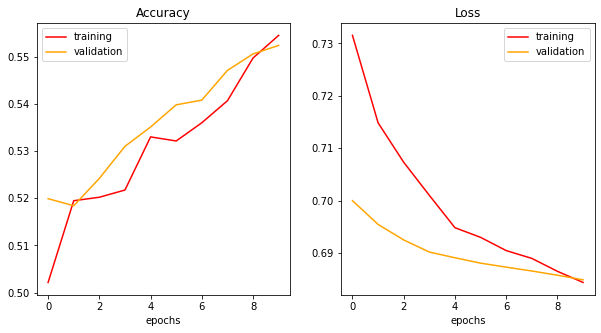

In [159]:
plot_graphs(history_with_glove, epoches)

In [160]:
loss_with_glove, accuracy_with_glove = model_with_glove.evaluate(X_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.6854 - accuracy: 0.5518


In [161]:
print('Loss: ', loss_with_glove)

Loss:  0.6853981018066406


In [162]:
print('Accuracy: ', accuracy_with_glove)

Accuracy:  0.551800012588501


In [163]:
model_with_glove.save('models/glove.h5')

### Zadaci: 
- Ispitati ponašanje mreža koje se duže treniraju. 
- Ispitati tok treniranja kada se koriste manji koraci učenja i nešto drugačija veličina paketića.